In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import sys
sys.path.append('../..') 
import evaluation
sys.path.append('../') 
import utils

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
from fastcore.basics import Path, AttrDict

In [4]:
import matplotlib.pyplot as plt

In [5]:
config = AttrDict(
    challenge_data_dir = Path('D:/SPLID/splid-devkit/data').expanduser(),
    valid_ratio = 0.1,
    lag_steps = 5
)

In [6]:
# Define the list of feature columns
feature_cols = [
    "Eccentricity",
    "Semimajor Axis (m)",
    "Inclination (deg)",
    "RAAN (deg)",
    "Argument of Periapsis (deg)",
    "True Anomaly (deg)",
    "Latitude (deg)",
    "Longitude (deg)",
    "Altitude (m)",
    "X (m)",
    "Y (m)",
    "Z (m)",
    "Vx (m/s)",
    "Vy (m/s)",
    "Vz (m/s)"
]

In [7]:
# Define the directory paths
train_data_dir = config.challenge_data_dir / "train"

# Load the ground truth data
ground_truth = pd.read_csv(config.challenge_data_dir / 'train_labels.csv')

# Apply the function to the ground truth data
data, updated_feature_cols = utils.tabularize_data(train_data_dir, feature_cols, 
                                          ground_truth, lag_steps=config.lag_steps)

# For each ObjectID, show the first rows of the columns TimeIndex, ObjectID, EW, and NS
data[['ObjectID', 'TimeIndex' , 'EW', 'NS']].groupby('ObjectID').head(2).head(10)

,ObjectID,TimeIndex,EW,NS
0,1,0,SS-HK,SS-HK
1,1,1,SS-HK,SS-HK
0,10,0,SS-CK,SS-NK
1,10,1,SS-CK,SS-NK
0,100,0,SS-CK,SS-CK
1,100,1,SS-CK,SS-CK
0,101,0,SS-CK,SS-NK
1,101,1,SS-CK,SS-NK
0,102,0,SS-CK,SS-NK
1,102,1,SS-CK,SS-NK


In [8]:
# Create a validation set without mixing the ObjectIDs
object_ids = data['ObjectID'].unique()
train_ids, valid_ids = train_test_split(object_ids,
                                        test_size=config.valid_ratio, 
                                        random_state=42)

train_data = data[data['ObjectID'].isin(train_ids)].copy()
valid_data = data[data['ObjectID'].isin(valid_ids)].copy()

ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(train_ids)].copy()
ground_truth_valid = ground_truth[ground_truth['ObjectID'].isin(valid_ids)].copy()

# Count the number of objects in the training and validation sets
print('Number of objects in the training set:', len(train_data['ObjectID'].unique()))
print('Number of objects in the validation set:', len(valid_data['ObjectID'].unique()))

Number of objects in the training set: 225
Number of objects in the validation set: 25


In [27]:
train_data['EW'].unique()

array(['SS-HK', 'SS-CK', 'SS-NK', 'AD-NK', 'IK-HK', 'IK-CK', 'ID-NK',
       'SS-EK', 'IK-EK'], dtype=object)

In [29]:
valid_data['EW'].unique()

array(['SS-NK', 'AD-NK', 'IK-HK', 'SS-CK', 'ID-NK', 'SS-HK', 'SS-EK'],
      dtype=object)

In [9]:
# Convert categorical data to numerical data
le_EW = LabelEncoder()
le_NS = LabelEncoder()

# Encode the 'EW' and 'NS' columns
train_data['EW_encoded'] = le_EW.fit_transform(train_data['EW'])
train_data['NS_encoded'] = le_NS.fit_transform(train_data['NS'])

In [32]:
train_data.head()

,Eccentricity,Semimajor Axis (m),Inclination (deg),RAAN (deg),Argument of Periapsis (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (m),X (m),...,Vy (m/s)_lag_5,Vz (m/s)_lag_1,Vz (m/s)_lag_2,Vz (m/s)_lag_3,Vz (m/s)_lag_4,Vz (m/s)_lag_5,EW,NS,EW_encoded,NS_encoded
0,0.000202,4.216537e+07,0.139822,94.427336,52.733092,277.810980,-0.014460,85.119506,3.578607e+07,1.783837e+07,...,1300.258746,6.534142,6.534142,6.534142,6.534142,6.534142,SS-HK,SS-HK,7,6
1,0.000214,4.216458e+07,0.140008,94.407240,59.443909,301.205730,-0.007812,85.122842,3.578177e+07,-3.716169e+06,...,1300.258746,6.534142,6.534142,6.534142,6.534142,6.534142,SS-HK,SS-HK,7,6
2,0.000231,4.216450e+07,0.140139,94.420500,64.355257,326.372111,0.001030,85.131695,3.577825e+07,-2.426888e+07,...,1300.258746,7.513546,6.534142,6.534142,6.534142,6.534142,SS-HK,SS-HK,7,6
3,0.000255,4.216524e+07,0.140147,94.419710,67.664873,353.158326,0.009633,85.144601,3.577642e+07,-3.828008e+07,...,1300.258746,6.465207,7.513546,6.534142,6.534142,6.534142,SS-HK,SS-HK,7,6
4,0.000277,4.216620e+07,0.140112,94.348243,70.366450,20.624466,0.015595,85.158717,3.577713e+07,-4.197225e+07,...,1300.258746,3.667072,6.465207,7.513546,6.534142,6.534142,SS-HK,SS-HK,7,6


In [33]:
train_data_X = train_data.iloc[:,:-4].values

In [34]:
train_data_Y_EW = train_data.iloc[:,-2].values
train_data_Y_NS = train_data.iloc[:,-1].values

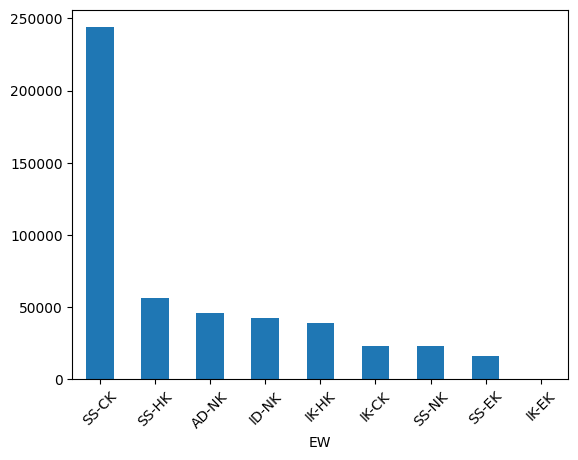

In [55]:
train_data['EW'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

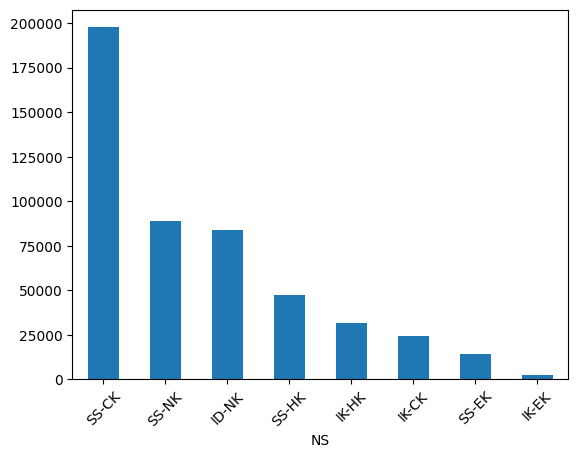

In [56]:
train_data['NS'].value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

In [10]:
# Standardize the data
scaler = StandardScaler()
train_data_X = scaler.fit_transform(train_data_X)

In [45]:
# Reshape the data for LSTM input (samples, time steps, features)
train_data_X = train_data_X.reshape((train_data_X.shape[0],1,train_data_X.shape[1]))

In [46]:
# Build the LSTM model for multi-class classification
EW_model = Sequential()
EW_model.add(LSTM(50, return_sequences=True,input_shape=(train_data_X.shape[1], train_data_X.shape[2])))
EW_model.add(Dropout(0.2))
EW_model.add(LSTM(50, return_sequences=False))
EW_model.add(Dropout(0.2))
EW_model.add(Dense(9, activation='softmax'))  # Output layer for multi-class classification

In [47]:
# Compile the model
EW_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
EW_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             28600     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 9)                 459       
                                                                 
Total params: 49259 (192.42 KB)
Trainable params: 49259 (192.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
#Train the model
EW_model.fit(train_data_X, train_data_Y_EW, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10


12261/12261 [==============================] - 77s 6ms/step - loss: 0.3176 - accuracy: 0.8816 - val_loss: 0.4111 - val_accuracy: 0.8669
Epoch 2/10
12261/12261 [==============================] - 67s 5ms/step - loss: 0.1654 - accuracy: 0.9376 - val_loss: 0.1195 - val_accuracy: 0.9448
Epoch 3/10
12261/12261 [==============================] - 66s 5ms/step - loss: 0.1380 - accuracy: 0.9482 - val_loss: 0.1004 - val_accuracy: 0.9639
Epoch 4/10
12261/12261 [==============================] - 64s 5ms/step - loss: 0.1243 - accuracy: 0.9533 - val_loss: 0.0521 - val_accuracy: 0.9809
Epoch 5/10
12261/12261 [==============================] - 58s 5ms/step - loss: 0.1149 - accuracy: 0.9570 - val_loss: 0.0780 - val_accuracy: 0.9769
Epoch 6/10
12261/12261 [==============================] - 60s 5ms/step - loss: 0.1091 - accuracy: 0.9592 - val_loss: 0.0723 - val_accuracy: 0.9758
Epoch 7/10
12261/12261 [==============================] - 59s 5ms/step - loss: 0.1047 - accuracy: 0.9607 - val_loss:

In [12]:
valid_data_X = valid_data.iloc[:,:-2].values

In [14]:
valid_data_X = scaler.fit_transform(valid_data_X)
valid_data_X = valid_data_X.reshape((valid_data_X.shape[0],1,valid_data_X.shape[1]))

In [56]:
# Make predictions
predictions = EW_model.predict(valid_data_X)

# If it's a classification model, convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)  # For multi-class classification
# For binary classification, you might use a threshold like 0.5 to convert probabilities to 0 or 1

# If you used label encoding, convert the numerical labels back to original labels
predicted_labels = le_EW.inverse_transform(predicted_classes)


1702/1702 [==============================] - 6s 3ms/step


In [57]:
predicted_labels

array(['SS-NK', 'SS-NK', 'SS-NK', ..., 'SS-CK', 'ID-NK', 'ID-NK'],
      dtype=object)

In [59]:
valid_data['Predicted_EW'] = predicted_labels

In [60]:
valid_data.head()

,Eccentricity,Semimajor Axis (m),Inclination (deg),RAAN (deg),Argument of Periapsis (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (m),X (m),...,Vy (m/s)_lag_5,Vz (m/s)_lag_1,Vz (m/s)_lag_2,Vz (m/s)_lag_3,Vz (m/s)_lag_4,Vz (m/s)_lag_5,EW,NS,EW_encoded,Predicted_EW
0,0.000141,4.224428e+07,0.150051,104.366296,48.629370,139.374252,0.025175,-65.223070,3.587068e+07,1.607924e+07,...,1168.669376,-7.965409,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,6,SS-NK
1,0.000138,4.224424e+07,0.150422,104.424876,43.956562,173.977589,0.005561,-65.316101,3.587189e+07,3.345573e+07,...,1168.669376,-7.965409,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,6,SS-NK
2,0.000148,4.224391e+07,0.150598,104.508808,39.059683,208.779144,-0.015721,-65.409636,3.587126e+07,4.187300e+07,...,1168.669376,-6.359744,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,6,SS-NK
3,0.000167,4.224357e+07,0.150618,104.537452,36.298070,241.502804,-0.032891,-65.501081,3.586880e+07,3.907641e+07,...,1168.669376,-3.044640,-6.359744,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,6,SS-NK
4,0.000188,4.224362e+07,0.150702,104.473202,34.455987,273.404296,-0.041227,-65.588052,3.586501e+07,2.581318e+07,...,1168.669376,1.097112,-3.044640,-6.359744,-7.965409,-7.965409,SS-NK,SS-NK,6,SS-NK


In [62]:
# Build the LSTM model for multi-class classification NS
NS_model = Sequential()
NS_model.add(LSTM(50, return_sequences=True,input_shape=(train_data_X.shape[1], train_data_X.shape[2])))
NS_model.add(Dropout(0.2))
NS_model.add(LSTM(50, return_sequences=False))
NS_model.add(Dropout(0.2))
NS_model.add(Dense(9, activation='softmax'))  # Output layer for multi-class classificatiNS

In [63]:
# Compile the model
NS_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
#Train the model
NS_model.fit(train_data_X, train_data_Y_NS, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
12261/12261 [==============================] - 52s 4ms/step - loss: 0.4243 - accuracy: 0.8432 - val_loss: 1.0356 - val_accuracy: 0.7862
Epoch 2/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.2461 - accuracy: 0.9052 - val_loss: 1.2297 - val_accuracy: 0.7284
Epoch 3/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.2037 - accuracy: 0.9213 - val_loss: 1.5552 - val_accuracy: 0.6765
Epoch 4/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.1831 - accuracy: 0.9289 - val_loss: 1.5555 - val_accuracy: 0.6874
Epoch 5/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.1695 - accuracy: 0.9338 - val_loss: 1.6081 - val_accuracy: 0.6844
Epoch 6/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.1614 - accuracy: 0.9373 - val_loss: 1.6598 - val_accuracy: 0.6599
Epoch 7/10
12261/12261 [==============================] - 48s 4ms/step - loss: 0.1539 - accuracy: 0.9398 - val_loss: 1

In [65]:
# Make predictions
predictions = NS_model.predict(valid_data_X)

# If it's a classification model, convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)  # For multi-class classification
# For binary classification, you might use a threshold like 0.5 to convert probabilities to 0 or 1

# If you used label encoding, convert the numerical labels back to original labels
predicted_labels = le_NS.inverse_transform(predicted_classes)


1702/1702 [==============================] - 4s 2ms/step


In [67]:
valid_data['Predicted_NS'] = predicted_labels

In [69]:
valid_data = valid_data.drop(columns=['EW_encoded'])

In [70]:
valid_data.head()

,Eccentricity,Semimajor Axis (m),Inclination (deg),RAAN (deg),Argument of Periapsis (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (m),X (m),...,Vy (m/s)_lag_5,Vz (m/s)_lag_1,Vz (m/s)_lag_2,Vz (m/s)_lag_3,Vz (m/s)_lag_4,Vz (m/s)_lag_5,EW,NS,Predicted_EW,Predicted_NS
0,0.000141,4.224428e+07,0.150051,104.366296,48.629370,139.374252,0.025175,-65.223070,3.587068e+07,1.607924e+07,...,1168.669376,-7.965409,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK
1,0.000138,4.224424e+07,0.150422,104.424876,43.956562,173.977589,0.005561,-65.316101,3.587189e+07,3.345573e+07,...,1168.669376,-7.965409,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK
2,0.000148,4.224391e+07,0.150598,104.508808,39.059683,208.779144,-0.015721,-65.409636,3.587126e+07,4.187300e+07,...,1168.669376,-6.359744,-7.965409,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK
3,0.000167,4.224357e+07,0.150618,104.537452,36.298070,241.502804,-0.032891,-65.501081,3.586880e+07,3.907641e+07,...,1168.669376,-3.044640,-6.359744,-7.965409,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK
4,0.000188,4.224362e+07,0.150702,104.473202,34.455987,273.404296,-0.041227,-65.588052,3.586501e+07,2.581318e+07,...,1168.669376,1.097112,-3.044640,-6.359744,-7.965409,-7.965409,SS-NK,SS-NK,SS-NK,SS-NK


In [72]:
valid_results = utils.convert_classifier_output(valid_data)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_valid, valid_results,tolerance=6)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the valid set: {precision:.2f}')
print(f'Recall for the valid set: {recall:.2f}')
print(f'F2 for the valid set: {f2:.2f}')
print(f'RMSE for the valid set: {rmse:.2f}')

Precision for the valid set: 0.00
Recall for the valid set: 0.80
F2 for the valid set: 0.02
RMSE for the valid set: 0.37


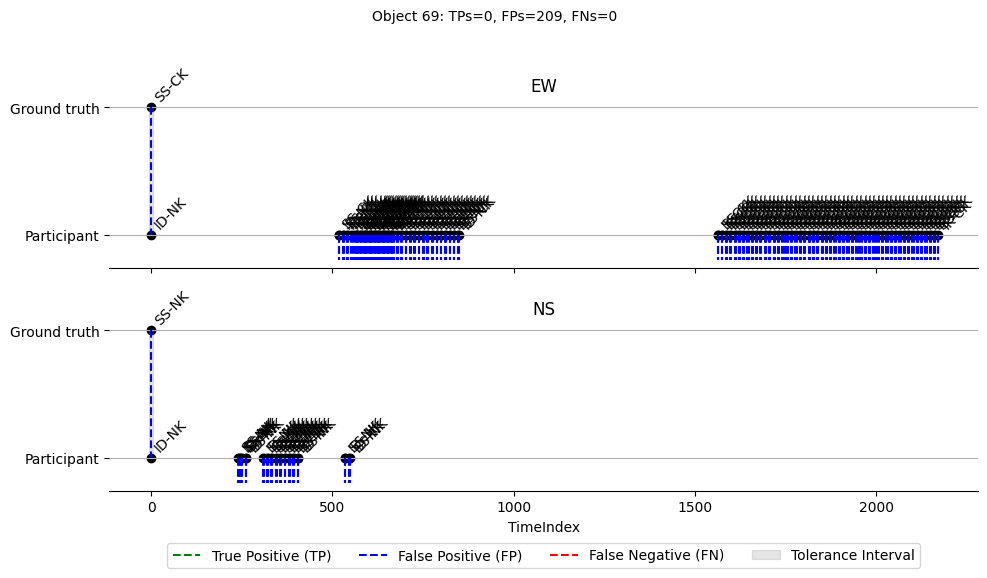

In [74]:
# Plot the evaluation timeline for a random ObjectID from the validation set
evaluator.plot(np.random.choice(valid_data['ObjectID'].unique()))

In [75]:
# Loop over the Object IDs in the training set and call the evaluation
# function for each object and aggregate the results
total_tp = 0
total_fp = 0
total_fn = 0
for oid in valid_data['ObjectID'].unique():
    tp, fp, fn, gt_object, p_object = evaluator.evaluate(oid)
    total_tp += tp
    total_fp += fp
    total_fn += fn

print(f'Total true positives: {total_tp}')
print(f'Total false positives: {total_fp}')
print(f'Total false negatives: {total_fn}')

Total true positives: 40
Total false positives: 9506
Total false negatives: 9


# Saved Model Inference section

In [15]:
import pickle

In [16]:
config.challenge_data_dir

Path('D:/SPLID/splid-devkit/data')

In [25]:
EW_model_file_path = Path('D:/SPLID/splid-devkit/baseline_submissions/ml_python/ML_solutions/trained_model/LSTM_model_EW.pkl')

In [26]:
with model_file_path.open("rb") as f:
    EW_model = pickle.load(f)

f.close()

PermissionError: [Errno 13] Permission denied: 'D:\\SPLID\\splid-devkit\\baseline_submissions\\ml_python\\ML_solutions\\trained_model'